In [57]:
import ete3
from matplotlib import pyplot as plt
import re
import numpy as np
import pandas as pd
import os
from Bio import AlignIO
ncbi = ete3.NCBITaxa()

#This script integrates key sequence/alignment features (for example, conserved residues) with tree displays.

In [58]:
fasta = AlignIO.read('proteinfasta.fa', 'fasta')
aa_state = {}
for block in fasta:
    aa_state[block.name.replace("|", '_').replace('/','_')] = block.seq[322]
#makes a "dictionary" out of your alignment, to use as a reference for site-specific labels later.
#the number specified for block.seq is the position in the alignment.
#Use alignment position - 1 as the correct position, because it designates position 1 as 0. so position 538 will be 537 in block.seq
#check:
block.seq[322],block.name

('F', 'Motiliproteus_sp._MSK22-1|WP_083704903.1/1-458')

In [59]:
phyla = {}
phyla.update(ncbi.get_name_translator(['Chloroflexi']))
phyla.update(ncbi.get_name_translator(['Proteobacteria']))
#phyla.update(ncbi.get_name_translator(['Firmicutes']))
phyla.update(ncbi.get_name_translator(['Archaea']))
phyla.update(ncbi.get_name_translator(['Cyanobacteria']))


In [60]:
phyla

{'Chloroflexi': [200795],
 'Proteobacteria': [1224],
 'Archaea': [2157],
 'Cyanobacteria': [1117]}

In [61]:
aa_state

{'NA4_Ga0104751_100161138_1-543': 'Q',
 'NA4_Ga0104751_10079453_1-519': 'Y',
 'UBA2323_DDVB01000054.1_19_1-541': 'Q',
 'UBA2356_DDTU01000187.1_4_1-541': 'Q',
 'UBA2395_DDSH01000008.1_42_1-541': 'Q',
 'UBA2414_DDRO01000022.1_63_1-541': 'Q',
 'UBA4733_DHIZ01000212.1_5_1-552': 'Q',
 'Chloroflexi_bacterium_RIK54890.1_1-541': 'Q',
 'Anaerolineae_bacterium_RIK31904.1_1-541': 'Q',
 'Ardenticatena_maritima_WP_054492071.1_1-542': 'Q',
 'Chloroflexi_bacterium_RME48457.1_1-534': 'Q',
 'Thermoflexus_hugenholtzii_JAD2_SNB72790.1_1-543': 'Q',
 'bacterium_HR22_GBD10104.1_1-543': 'Q',
 'Chloroflexi_bacterium_RBG_16_57_8_OGO35735.1_1-506': 'Q',
 'Gemmatimonadetes_bacterium_RMH18752.1_1-545': 'Q',
 'Gammaproteobacteria_bacterium_RIFCSPLOWO2_01_FULL_47_190_OGT65323.1_1-534': 'Q',
 'Nitrospirae_bacterium_RBG_16_64_22_OGW58859.1_1-500': 'Q',
 'Rhodospirillales_bacterium_RIFCSPLOWO2_12_FULL_67_15_OHC82257.1_1-534': 'Q',
 'Nitrospinae_bacterium_RIFCSPLOWO2_01_FULL_39_10_OGW04603.1_1-500': 'Q',
 'Deltaproteob

In [62]:
#loads tree, renames tips for readability, gets NCBI name translator for tips, and removes selected taxa by name
nortree = ete3.Tree('fastatree.treefile',
                    format = 1)
human_readable_names = []
leaf_name_convert    = {}
for leaf in nortree.get_leaf_names():
    regex = re.match('(?:Candidatus_)?([A-Z][a-z]+_[a-z]+)', leaf)
    
    if regex:
        taxon_name = regex.group(1).replace('_', ' ')
        if taxon_name.endswith(' sp') or\
           taxon_name.endswith(' bacterium') or \
           taxon_name.endswith(' archaeon') or \
           taxon_name.endswith(' bacteria'):
            taxon_name = taxon_name.split()[0]
            
        human_readable_names.append(taxon_name)
        leaf_name_convert[leaf] = taxon_name
    else:
        if leaf.startswith('UBA') or\
           leaf.startswith('SA' ) or \
           leaf.startswith('Jd' ) or \
           leaf.startswith('NA' ): 
            taxon_name = 'Chloroflexi'
            leaf_name_convert[leaf] = taxon_name
            human_readable_names.append(taxon_name)
        else:
            print(leaf)
leaf_taxonomy = ncbi.get_name_translator(human_readable_names)

bacterium_RIL08403.1_1-522
bacterium_RIL08691.1_1-538
Simplicispira_WP_116005656.1_1-533
Wenzhouxiangella_WP_116898261.1_1-532
Thermus_WP_015717644.1_1-362
haloarchaeon_3A1_DGR_WP_021073977.1_1-546
Halorubrum_WP_094527696.1_1-546
bacterium_HR22_GBD10104.1_1-543


In [63]:
#makes df of taxonomic data, with NCBI taxid info

x, y, z, a, b = [], [], [], [], []
for leaf, taxon_name in leaf_name_convert.items():
    x.append(leaf)
    y.append(taxon_name)
    if taxon_name in leaf_taxonomy.keys():
        z.append(leaf_taxonomy[taxon_name][0])
        tmp_lineage = ncbi.get_lineage(z[-1])
        phylum_flag = False
        for phylum, [phylum_id] in phyla.items():
            if phylum_id in tmp_lineage:
                b.append(phylum)
                phylum_flag = True
                break
        if not phylum_flag:
            b.append(None)
        a.append(ncbi.get_lineage(z[-1]))
    else:
        z.append(None)
        a.append([])
        b.append(None)


leaf_df = pd.DataFrame(columns=['leaf', ' taxon', 'tax_id', 'lineage', 'phylum'], 
                       data=list(zip(x, y, z, a, b, )))
leaf_df.set_index('leaf', inplace=True)

leaf_df.head()

,taxon,tax_id,lineage,phylum
leaf,,,,
NA4_Ga0104751_100161138_1-543,Chloroflexi,200795.0,"[1, 131567, 2, 1783272, 200795]",Chloroflexi
NA4_Ga0104751_10079453_1-519,Chloroflexi,200795.0,"[1, 131567, 2, 1783272, 200795]",Chloroflexi
Bacillus_methanolicus_WP_004436565.1_1-536,Bacillus methanolicus,1471.0,"[1, 131567, 2, 1783272, 1239, 91061, 1385, 186...",None
Halomicrobium_mukohataei_WP_012807535.1_1-551,Halomicrobium mukohataei,57705.0,"[1, 131567, 2157, 28890, 2290931, 183963, 2235...",Archaea
Pyrobaculum_ferrireducens_AET32186.1_1-528,Pyrobaculum ferrireducens,1104324.0,"[1, 131567, 2157, 1783275, 28889, 183924, 2266...",Archaea


In [64]:
#sets branch colors by taxonomy
phylum_color = {i:j for i, j in zip(phyla.keys(), ['#cc3311', '#0072B2','#E69F00','#56B4E9'])}

In [65]:
#sets branch styles and colors
phylum_edge_styles = {}
for phylum, color in zip(phyla.keys(), ['#cc3311', '#0072B2','#E69F00','#56B4E9']):
    phylum_edge_styles[phylum] = ete3.NodeStyle()
    phylum_edge_styles[phylum]["vt_line_color"] = color
    phylum_edge_styles[phylum]["hz_line_color"] = color
    phylum_edge_styles[phylum]["vt_line_width"] = 7
    phylum_edge_styles[phylum]["hz_line_width"] = 7
    phylum_edge_styles[phylum]["vt_line_type"]  = 0
    phylum_edge_styles[phylum]["hz_line_type"]  = 0
    phylum_edge_styles[phylum]["size"]          = 0

In [66]:
for node in nortree.traverse():
    if not node.is_leaf() and node.name:
        alrt, ufboot = node.name.split('/')
        node.add_feature('aLRT', alrt)
        node.add_feature('UFBoot', ufboot)

for leaf in nortree.get_leaves():
    leaf.add_feature('aa',aa_state[leaf.name])

In [67]:

#Midpoint root your tree
#mpt = nortree.get_midpoint_outgroup()
# and set it as tree outgroup
#nortree.set_outgroup(mpt)

#avoid setting outgroup to root if there's a mismatch
#randomleaf = nortree.get_common_ancestor('Thermus_thermophilus_VCU54789.1_1-561', 'Thermus_WP_015717644.1_1-383')
#nortree.set_outgroup(randomleaf)

#Comment out if using manual rooting (below)

In [68]:
#Force root your tree
rootanc = nortree.get_common_ancestor("Actinobacteria_bacterium_RBG_16_68_12_OFW73639.1_1-272", "Gemmobacter_megaterium_WP_076534164.1_1-526")
print (rootanc)
nortree.set_outgroup(rootanc)

#Comment out if using midpoint rooting (above)


               /-NA4_Ga0104751_10079453_1-519
            /-|
           |  |   /-Bacillus_methanolicus_WP_004436565.1_1-536
           |   \-|
           |     |   /-Halomicrobium_mukohataei_WP_012807535.1_1-551
         /-|      \-|
        |  |        |   /-Pyrobaculum_ferrireducens_AET32186.1_1-528
        |  |         \-|
        |  |            \-Methyloferula_stellata_WP_020177359.1_1-518
      /-|  |
     |  |   \-Acidianus_hospitalis_WP_013774846.1_1-527
     |  |
     |  |   /-bacterium_RIL08403.1_1-522
     |   \-|
     |     |   /-Euryarchaeota_archaeon_PXF18200.1_1-539
     |      \-|
     |        |   /-Rhodobacterales_bacterium_RIFCSPHIGHO2_02_FULL_62_130_OHC58500.1_1-538
     |         \-|
     |           |   /-Rhodoferax_sp._OTU1_WP_114968572.1_1-536
     |            \-|
     |              |   /-Paracoccus_aestuarii_WP_119884779.1_1-534
   /-|               \-|
  |  |                 |   /-Rhodobaca_barguzinensis_WP_071479651.1_1-526
  |  |                  \-|
  |

In [69]:
#colors branches and crown

clades_to_color = {}
for node in nortree.traverse():
    if node.is_leaf() or node.is_root():
        continue

    catalogd_taxa = leaf_df.index.intersection(node.get_leaf_names())
    present_phyla = leaf_df.loc[catalogd_taxa, 'phylum'].unique()

    if len(present_phyla) == 1 and present_phyla[0] != None:

        if present_phyla[0] not in clades_to_color:
            clades_to_color[present_phyla[0]] = []

        if set(clades_to_color[present_phyla[0]]).intersection(node.get_ancestors()):
            continue
        else:
            clades_to_color[present_phyla[0]].append(node)
            node.set_style(phylum_edge_styles[present_phyla[0]])

In [70]:
for phylum, clades in clades_to_color.items():
    for clade in clades:
        for node in clade.traverse():
                if not node.is_leaf():
                    node.set_style(phylum_edge_styles[phylum])

In [71]:
#Color leaves by amino acid state (in this case red for target AA, blue for alternate AA, black for mutations/not interesting)

for node in nortree.traverse():
    if node.is_leaf():
        node.img_style['size'] = 7

        try:
            phylum = leaf_df.loc[node.name, 'phylum']
            color = phylum_color[phylum]
        except KeyError:
            pass
        else:
            if set(clades_to_color[phylum]).intersection(node.get_ancestors()):
                node.img_style["vt_line_color"] = color
                node.img_style["hz_line_color"] = color
                node.img_style["vt_line_width"] = 7
                node.img_style["hz_line_width"] = 7
                node.img_style["vt_line_type"]  = 0
                node.img_style["hz_line_type"]  = 0
        
        if node.aa == 'Y':
            node.img_style['fgcolor'] = 'blue'
        elif node.aa == 'Q':
            node.img_style['fgcolor'] = 'red'
        else:
            node.img_style['fgcolor'] = 'black'
    else:
        node.img_style['size'] = 0

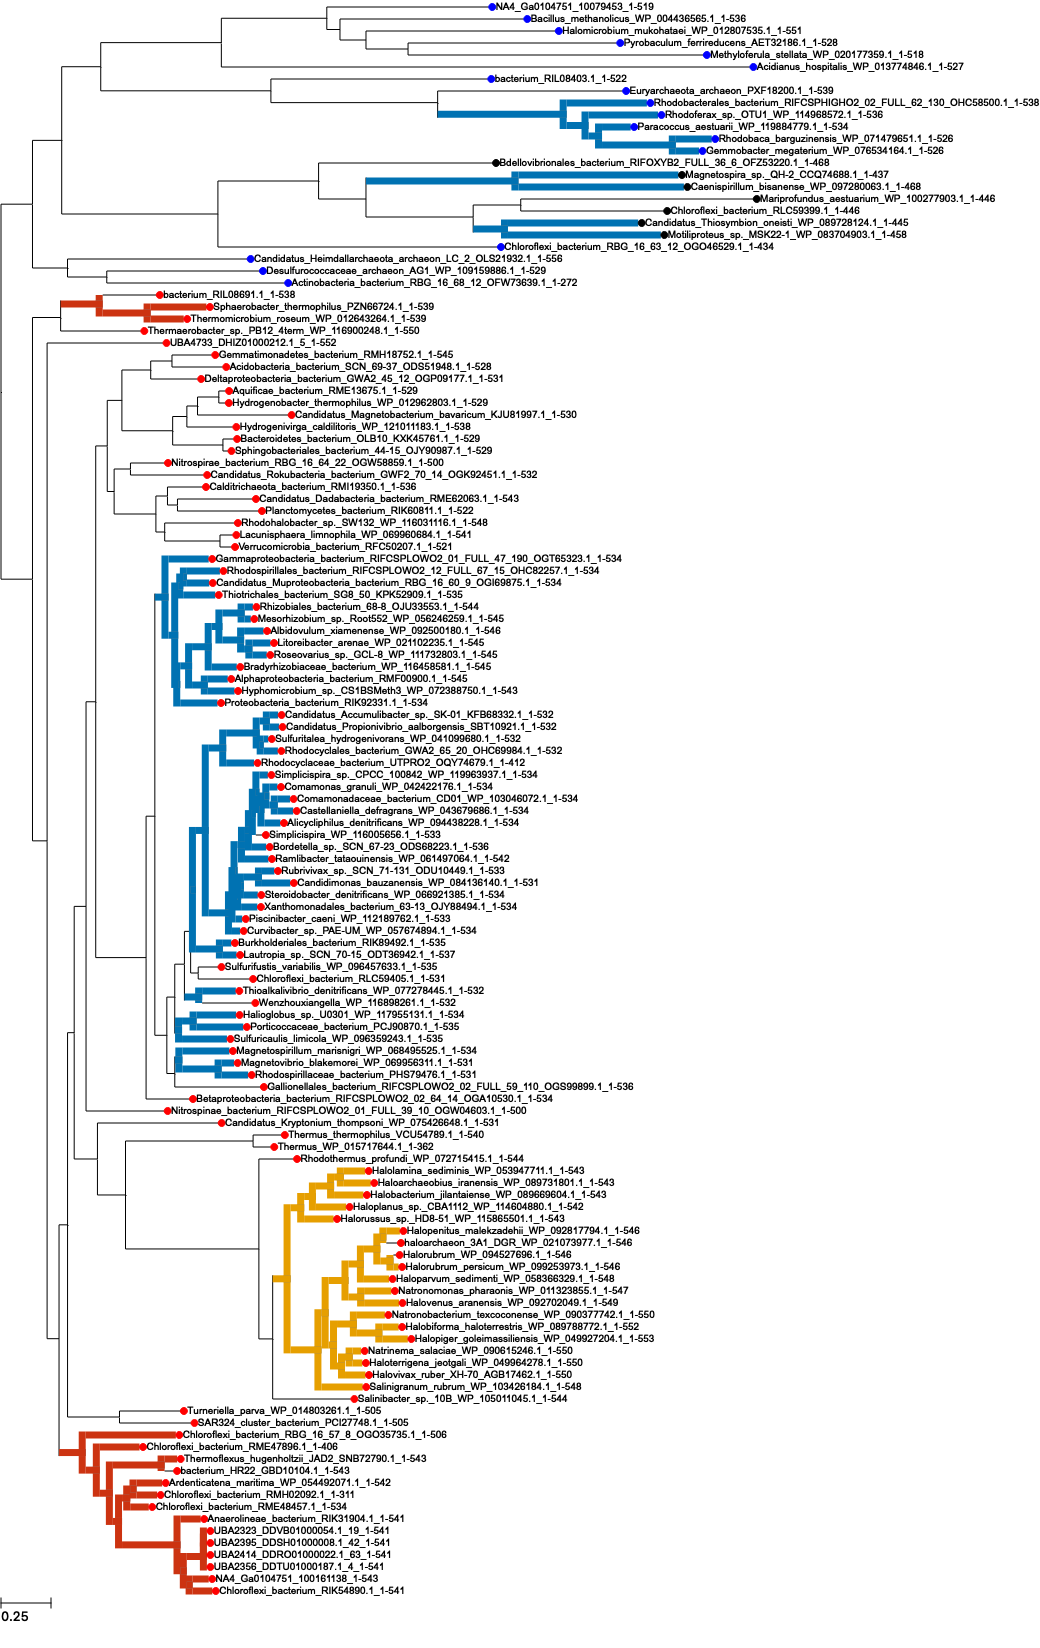

In [72]:
#Render tree inline (comment out any undesired specifications)
tStyle = ete3.TreeStyle()
tStyle.scale = 200
#tStyle.show_branch_length = True
#tStyle.show_branch_support = True
nortree.render('%%inline', tree_style=tStyle)

In [73]:
#Render tree as file 
nortree.render(file_name = 'Jan_ete_NorTree.svg',tree_style=tStyle)

{'nodes': [[488.26727178000004, 3.0, 496.26727178000004, 11.0, 6, None],
  [523.3186097600001, 15.0, 531.3186097600001, 23.0, 8, None],
  [554.7967633000001, 27.0, 562.7967633000001, 35.0, 10, None],
  [616.2724917800001, 39.0, 624.2724917800001, 47.0, 12, None],
  [702.8321454800001, 51.0, 710.8321454800001, 59.0, 13, None],
  [749.41894246, 63.0, 757.41894246, 71.0, 14, None],
  [487.31907316, 75.0, 495.31907316, 83.0, 16, None],
  [622.15418538, 87.0, 630.15418538, 95.0, 18, None],
  [646.3902013000001, 99.0, 654.3902013000001, 107.0, 20, None],
  [657.51313078, 111.0, 665.51313078, 119.0, 22, None],
  [630.1983506400001, 123.0, 638.1983506400001, 131.0, 24, None],
  [711.26433688, 135.0, 719.26433688, 143.0, 26, None],
  [698.55658232, 147.0, 706.55658232, 155.0, 27, None],
  [492.05705181999997, 159.0, 500.05705181999997, 167.0, 30, None],
  [677.9409467400001, 171.0, 685.9409467400001, 179.0, 33, None],
  [683.40666736, 183.0, 691.40666736, 191.0, 34, None],
  [752.7467761, 195.0